In [157]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import scipy.spatial.distance
from scipy.stats import multivariate_normal

# Linear regression: uncertainty in uncertainty

Let's say we have a data in x and y axes as below:

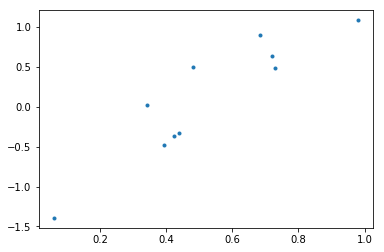

In [26]:
x = np.array([0.0596779, 0.34317802, 0.39211752, 0.42310646, 0.43857224, 0.4809319, 0.68482974,
              0.71946897, 0.72904971, 0.9807642])
y = np.array([-1.39284066, 0.02093466, -0.48427289, -0.36730135, -0.33372661, 0.49791066,
              0.89920648, 0.63361326, 0.47788066, 1.07935026])
plt.plot(x, y, '.')
plt.show()

With the data given above, we would like to fit it with a linear regression **y = a + bx**. That is, we would like to determine the coefficients and its error in different cases:

1. Assuming the model is correct and the error is known
2. Assuming the model is correct and the error is unknown
3. The model has an assumed inadequacy and the error is unknown

## Known correct model & known error

In this first case, we will determine the uncertainty of the coefficients if we know the standard deviation of the data.
The way we invert it is using Bayesian inference with the help from `emcee` sampler.

The probability density function of the coefficients can be written as

$$\begin{equation}
P(a,b | \mathcal{D}) \propto P(\mathcal{D} | a, b) P(a, b)
\end{equation}$$

Assuming flat prior of \\(a, b\\), we can write the probability of the coefficients as

$$\begin{align}
P(a,b | \mathcal{D}) &\propto P(\mathcal{D} | a, b) \\
& \propto \exp\left[-\sum_i \frac{(a+bx_i-y_i)^2}{2\sigma^2}\right]
\end{align}$$

From the expression above, we can draw samples of \\(a,b\\) using the `emcee` sampler.

In [83]:
def lnprob1(param, x, y):
    param = np.array(param)
    a = param[0]
    b = param[1]
    sigma = 0.28297849805199204
    return -np.sum((a + b * x - y)**2) / (2 * sigma**2)

In [84]:
ndim, nwalkers = 2, 100
ivar = 1. / np.random.rand(ndim)
p0 = [np.random.rand(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob1, args=[x, y])
pos, prob, state = sampler.run_mcmc(p0, 10000)

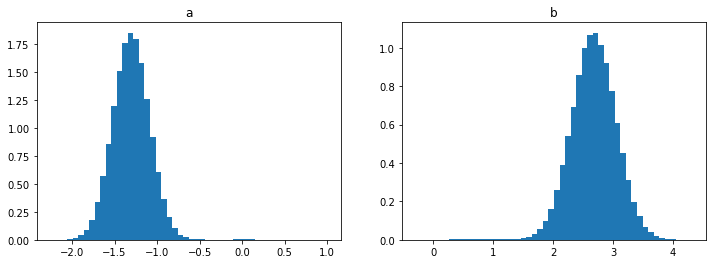

a: -1.301090 +- 0.223953 (true: -1.085631)
b: 2.674668 +- 0.380601 (true: 1.994691)


In [85]:
a_post1 = sampler.flatchain[10000:,0]
b_post1 = sampler.flatchain[10000:,1]
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(a_post1, 50, normed=True)
plt.title("a")
plt.subplot(1,2,2)
plt.hist(b_post1, 50, normed=True)
plt.title("b")
plt.show()

print("a: %f +- %f (true: %f)" % (np.mean(a_post1), np.std(a_post1), -1.0856306033005612))
print("b: %f +- %f (true: %f)" % (np.mean(b_post1), np.std(b_post1), 1.9946908931671716))

## Known correct model and unknown error

In this case, we don't know quite sure what the error was, so we put a prior uncertainty of the \\(\sigma\\) and get the posterior belief on that as well as the other coefficients.

The probability density function of the coefficients can be written as

$$\begin{equation}
P(a,b,\sigma | \mathcal{D}) \propto P(\mathcal{D} | a, b, \sigma) P(a, b) P(\sigma)
\end{equation}$$

As before, the prior of \\(a, b\\) is assumed flat. However, we assumed the \\(\sigma\\) to have the flat log prior. Therefore, we can write the probability of the coefficients as

$$\begin{align}
P(a,b,\sigma | \mathcal{D}) &\propto P(\mathcal{D} | a, b, \sigma) \frac{1}{\sigma} \\
& \propto \exp\left[-\sum_i \frac{(a+bx_i-y_i)^2}{2\sigma^2}\right] \frac{1}{\sigma^{N+1}}
\end{align}$$
where \\(N\\) is the number of data samples.

From the expression above, we can draw samples of \\(a,b, \sigma\\) using the `emcee` sampler.

In [153]:
def lnprob2(param, x, y):
    a, b, sigma = param
    if sigma < 0: return -np.inf
    
    ymodel = a + b * x
    N = len(x)
    return - np.sum((ymodel - y)**2) / (2*sigma**2) - (N+1) * np.log(sigma)

In [154]:
ndim, nwalkers = 3, 100
p0 = np.random.random((nwalkers, ndim))

sampler2 = emcee.EnsembleSampler(nwalkers, ndim, lnprob2, args=[x, y])
pos, prob, state = sampler2.run_mcmc(p0, 10000)

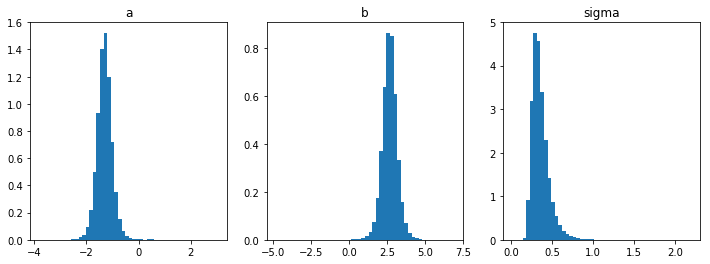

a: -1.298608 +- 0.297102 (true: -1.085631)
b: 2.671602 +- 0.503924 (true: 1.994691)
sigma: 0.362446 +- 0.108571 (true: 0.282978)


In [152]:
a_post2 = sampler2.flatchain[10000:,0]
b_post2 = sampler2.flatchain[10000:,1]
s_post2 = sampler2.flatchain[10000:,2]
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(a_post2, 50, normed=True)
plt.title("a")
plt.subplot(1,3,2)
plt.hist(b_post2, 50, normed=True)
plt.title("b")
plt.subplot(1,3,3)
plt.hist(s_post2, 50, normed=True)
plt.title("sigma")
plt.show()

print("a: %f +- %f (true: %f)" % (np.mean(a_post2), np.std(a_post2), -1.0856306033005612))
print("b: %f +- %f (true: %f)" % (np.mean(b_post2), np.std(b_post2), 1.9946908931671716))
print("sigma: %f +- %f (true: %f)" % (np.mean(s_post2), np.std(s_post2), 0.28297849805199204))

## Unknown correct model and unknown error 

This is similar to the previous case, except that we are not sure that the linear model is the correct one. One way to encode our uncertainty is to express the observation as

$$\begin{equation}
\hat{y}(x) = a + bx + \varepsilon + \eta(x)
\end{equation}$$

where \\(\varepsilon \sim \mathcal{N}(0, \sigma^2)\\) is the Gaussian noise and \\(\eta(x)\\) is the model inadequacy. Let's assume the model inadequacy is a Gaussian process with mean zero and squared exponential kernel:

$$\begin{align}
\eta(x) & \sim \mathcal{GP}\left[0, c(\cdot, \cdot)\right] \\
c(x_1, x_2) & = m^2 \exp\left[-\frac{(x_1 - x_2)^2}{2 d^2}\right]
\end{align}$$

To encode the Gaussian noise and the Gaussian process in one expression, we can write it as

$$\begin{align}
(\eta(x) + \varepsilon) & \sim \mathcal{GP}\left[0, c_2(\cdot, \cdot)\right] \\
c_2(x_1, x_2) & = m^2 \exp\left[-\frac{(x_1 - x_2)^2}{2 d^2}\right] + \delta(x_1-x_2) \sigma^2
\end{align}$$

where \\(\delta\\) term is one when the argument is zero and zero otherwise.


The posterior distribution is given by

$$\begin{equation}
P(a,b,\sigma,m,d | \mathcal{D}) \propto P(\mathcal{D} | a, b, \sigma, m, d) P(a, b) P(\sigma) P(m) P(d)
\end{equation}$$

As before, the prior of \\(a, b\\) is assumed flat and \\(\sigma\\) to have the flat log prior. Here we also assume \\(m,d\\) to have the flat log prior. Thus, we can write the probability of the coefficients as

$$\begin{align}
P(a,b,\sigma,m,d | \mathcal{D}) &\propto P(\mathcal{D} | a, b, \sigma, m, d) \frac{1}{\sigma m d} \\
& \propto \mathcal{GP}\left[\hat{y}; a + bx, c_2(\cdot, \cdot)\right] \frac{1}{\sigma m d}
\end{align}$$

From the expression above, we can draw samples of \\(a,b, \sigma, m, d\\) using the `emcee` sampler.

In [193]:
def lnprob3(param, x, y, dist):
    a, b, sigma, m, d = param
    if sigma < 0 or m < 0 or d < 0: return -np.inf
    if d > 1: return -np.inf
    
    # calculate the covariance matrix
    cov = m*m * np.exp(-dist**2/(2*d*d)) + np.eye(len(x)) * (sigma*sigma)
    # cov = np.eye(len(x)) * (sigma * sigma)
    
    ymodel = a + b * x
    obs = ymodel - y
    return multivariate_normal.logpdf(obs, mean=np.zeros(obs.shape[0]), cov=cov) - np.log(sigma * m * d)

In [194]:
dist = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(np.expand_dims(x, 1)))

In [198]:
ndim, nwalkers = 5, 100
p0 = np.random.random((nwalkers, ndim))

sampler3 = emcee.EnsembleSampler(nwalkers, ndim, lnprob3, args=[x, y, dist])
pos, prob, state = sampler3.run_mcmc(p0, 100000)

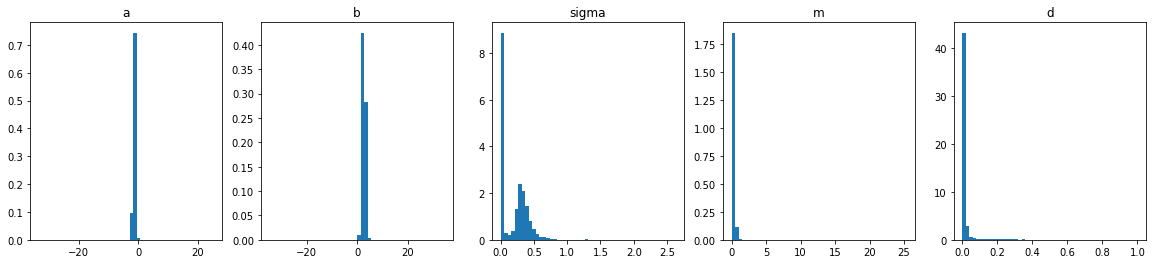

a: -1.302273 +- 0.331669 (true: -1.085631)
b: 2.682363 +- 0.546369 (true: 1.994691)
sigma: 0.183237 +- 0.193064 (true: 0.282978)
m: 0.202844 +- 0.245070
d: 0.026837 +- 0.111431


In [199]:
nburn = 10000
a_post3 = sampler3.flatchain[nburn:,0]
b_post3 = sampler3.flatchain[nburn:,1]
s_post3 = sampler3.flatchain[nburn:,2]
m_post3 = sampler3.flatchain[nburn:,3]
d_post3 = sampler3.flatchain[nburn:,4]
plt.figure(figsize=(20,4))
plt.subplot(1,5,1)
plt.hist(a_post3, 50, normed=True)
plt.title("a")
plt.subplot(1,5,2)
plt.hist(b_post3, 50, normed=True)
plt.title("b")
plt.subplot(1,5,3)
plt.hist(s_post3, 50, normed=True)
plt.title("sigma")
plt.subplot(1,5,4)
plt.hist(m_post3, 50, normed=True)
plt.title("m")
plt.subplot(1,5,5)
plt.hist(d_post3, 50, normed=True)
plt.title("d")
plt.show()

print("a: %f +- %f (true: %f)" % (np.mean(a_post3), np.std(a_post3), -1.0856306033005612))
print("b: %f +- %f (true: %f)" % (np.mean(b_post3), np.std(b_post3), 1.9946908931671716))
print("sigma: %f +- %f (true: %f)" % (np.mean(s_post3), np.std(s_post3), 0.28297849805199204))
print("m: %f +- %f" % (np.mean(m_post3), np.std(m_post3)))
print("d: %f +- %f" % (np.mean(d_post3), np.std(d_post3)))

## Conclusions

We have compared the retrieved coefficients with different degrees of uncertainty: (1) known model and known error, (2) known model and unknown error, and (3) unknown model and unknown error. Here are the comparisons of the retrieved coefficients for those three cases.

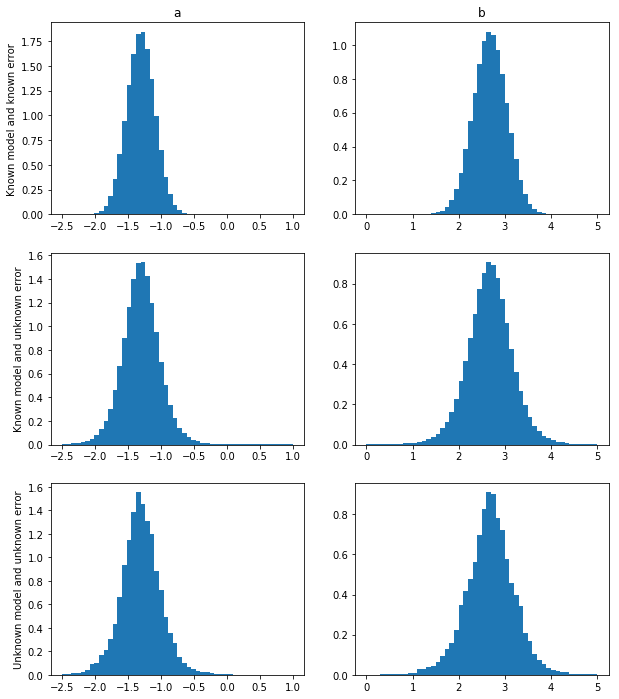

In [204]:
plt.figure(figsize=(10, 12))
a_xlim = (-2.5, 1)
b_xlim = (0, 5)

plt.subplot(3,2,1)
plt.hist(a_post1, 50, normed=True, range=a_xlim)
plt.title("a")
plt.ylabel("Known model and known error")
plt.subplot(3,2,2)
plt.hist(b_post1, 50, normed=True, range=b_xlim)
plt.title("b")

plt.subplot(3,2,3)
plt.hist(a_post2, 50, normed=True, range=a_xlim)
plt.ylabel("Known model and unknown error")
plt.subplot(3,2,4)
plt.hist(b_post2, 50, normed=True, range=b_xlim)

plt.subplot(3,2,5)
plt.hist(a_post3, 50, normed=True, range=a_xlim)
plt.ylabel("Unknown model and unknown error")
plt.subplot(3,2,6)
plt.hist(b_post3, 50, normed=True, range=b_xlim)

plt.show()

### Data generator

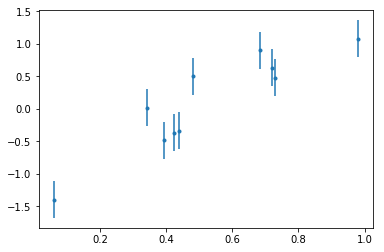

[ 0.0596779   0.34317802  0.39211752  0.42310646  0.43857224  0.4809319
  0.68482974  0.71946897  0.72904971  0.9807642 ]
[-1.39284066  0.02093466 -0.48427289 -0.36730135 -0.33372661  0.49791066
  0.89920648  0.63361326  0.47788066  1.07935026]
(-1.0856306033005612, 1.9946908931671716, 0.28297849805199204)


In [27]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(123)
size = (10,)
a = np.random.randn()
b = np.random.randn() * 2
sigma = np.abs(np.random.randn() * 1)
x = np.sort(np.random.random(size))
y = a + b * x + np.random.randn(*size) * sigma

plt.errorbar(x, y, yerr=sigma, fmt='.')
plt.show()

print(x)
print(y)
print(a, b, sigma)